In [651]:
!pip install transformers -q

In [652]:
!pip install sentencepiece -q

In [653]:
!pip install pythainlp -q

In [741]:
import pandas as pd
import re
import torch
from sklearn.model_selection import train_test_split
import ast
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.jit import script, trace       # hybrid frontend decorator and tracing jit

In [742]:
train_df = pd.read_csv('/content/train_finaldata.csv', index_col = 0)
test_df = pd.read_csv('/content/super3_test_title.csv', index_col = 0)
# pat_df = pd.read_csv('/kaggle/input/legal-act-classification/patterns.csv')

In [744]:
train_df

,rgno,context,pattern,question,legal_act,condition,answer,rgno_id
id,,,,,,,,
0,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['P0030'],การทำนิติกรรม สำนักงานตรวจคนเข้าเมือง,NaN,0.0,"{'นายนรากรณ์ ดีเย็น': 'P0265', 'นายนภัสกร แซ่เ..."
1,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['P0260'],การทำนิติกรรม กรมทางหสวง,NaN,0.0,"{'นายนรากรณ์ ดีเย็น': 'P0265', 'นายนภัสกร แซ่เ..."
2,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['P0164'],อสังหาริมทรัพย์,NaN,0.0,"{'นายนรากรณ์ ดีเย็น': 'P0265', 'นายนภัสกร แซ่เ..."
3,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['P0005'],การทำนิติกรรม หน่วยราชการวิสาหกิจ,NaN,0.0,"{'นายนรากรณ์ ดีเย็น': 'P0265', 'นายนภัสกร แซ่เ..."
4,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['P0265'],อสังหาริมทรัพย์,NaN,0.0,"{'นายนรากรณ์ ดีเย็น': 'P0265', 'นายนภัสกร แซ่เ..."
...,...,...,...,...,...,...,...,...
6016,1.075360e+11,กรรมการสองในเจ็ดคนลงลายมือชื่อร่วมกันและประทับ...,11004,"['P0293', 'P0118', 'P0187', 'P0031']",สัญญาเช่า,NaN,1.0,"{'นายพงศกร ชัยแก้ว': 'P0118', 'นายวิธวินท์ ศรี..."
6017,1.075360e+11,กรรมการสองในเจ็ดคนลงลายมือชื่อร่วมกันและประทับ...,11004,"['P0293', 'P0118', 'P0187', 'P0099']",ทำนา,NaN,1.0,"{'นายพงศกร ชัยแก้ว': 'P0118', 'นายวิธวินท์ ศรี..."
6018,1.075360e+11,กรรมการสองในเจ็ดคนลงลายมือชื่อร่วมกันและประทับ...,11004,"['P0293', 'P0118', 'P0187', 'P0096']",ธนาคาร,NaN,1.0,"{'นายพงศกร ชัยแก้ว': 'P0118', 'นายวิธวินท์ ศรี..."


In [745]:
train_df['legal_act'].fillna(method='ffill', inplace=True)

In [746]:
test_df.loc[4426, 'context']

'P0241 ลงลายมือชื่อร่วมกับกรรมการอื่นอีกสองคน และประทับตราสำคัญของบริษัท หรือ P0047 , P0099 , P0272 , P0259 และ P0490 ลงลายมือชื่อร่วมกันและประทับตราสำคัญของบริษัท'

In [747]:
train_df['Text'] = train_df['context'] + ', ' + train_df['question'] + ', ' + train_df['legal_act']
train_df['Label'] = train_df['answer']
df = train_df[['Text', 'Label']]

test_df['Text'] = test_df['context'] + ', ' + test_df['question'] + ', ' + test_df['legal_act']
df_test = test_df[['Text']]

In [660]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4429 entries, 0 to 4428
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         4429 non-null   int64  
 1   rgno       4429 non-null   float64
 2   context    4429 non-null   object 
 3   pattern    4429 non-null   int64  
 4   question   4429 non-null   object 
 5   legal_act  4429 non-null   object 
 6   condition  428 non-null    object 
 7   answer     4429 non-null   int64  
 8   rgno_id    4429 non-null   object 
 9   Text       4429 non-null   object 
 10  Label      4429 non-null   int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 415.2+ KB


In [661]:
# train_df['Text'] = train_df['context'] + ', ' + train_df['question']
# train_df['Label'] = train_df['answer']
# df = train_df[['Text', 'Label']]

<Axes: title={'center': 'Answer'}, ylabel='Frequency'>

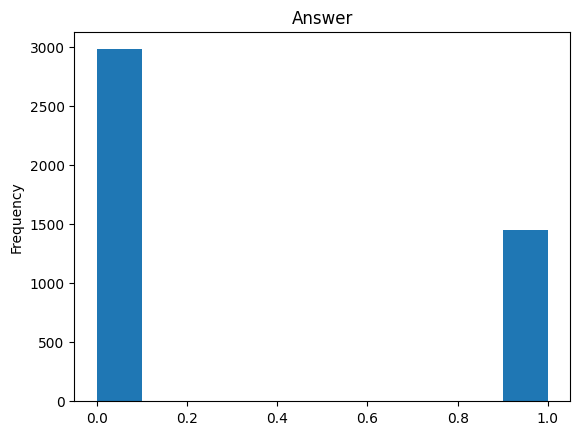

In [662]:
df.Label.plot(kind = 'hist',title = 'Answer')

In [663]:
train_set, val_set = train_test_split( df, test_size=0.20, random_state=42)  # test_size=0.20 for 80:20 split

train_set.reset_index(drop=True, inplace = True)
val_set.reset_index(drop=True, inplace = True)

# Print the shape of the datasets to verify the sizes
print(f"Training set shape: {train_set.shape}")
print(f"Validation set shape: {val_set.shape}")

Training set shape: (3543, 2)
Validation set shape: (886, 2)


In [739]:
name = train_df['Text'].sample(1).values[0]
name

"กรรมการสองในสี่คน ลงลายมือชื่อร่วมกัน, ['P0501', 'P0225'], การทำนิติกรรม การนิคมอุตสาหกรรม"

In [740]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")
print(tokenizer.tokenize(name))
tokenizer.add_tokens(['P0185', 'P0168', 'P0120', 'P0234', 'P0264', 'P0254'])
# encoded = tokenizer(name, padding=True, truncation=True, return_tensors='pt')
print(tokenizer.tokenize(name))

['▁', 'กรรมการ', 'สอง', 'ใน', 'สี่คน', '▁', 'ลง', 'ลายมือชื่อ', 'ร่วมกัน', ',', '▁[', "'", 'P', '05', '01', "'", ',', "▁'", 'P', '02', '25', "'", ']', ',', '▁', 'การทํา', 'นิติกรรม', '▁การ', 'นิคม', 'อุตสาหกรรม']
['▁', 'กรรมการ', 'สอง', 'ใน', 'สี่คน', '▁', 'ลง', 'ลายมือชื่อ', 'ร่วมกัน', ',', '▁[', "'", 'P', '05', '01', "'", ',', "▁'", 'P', '02', '25', "'", ']', ',', '▁', 'การทํา', 'นิติกรรม', '▁การ', 'นิคม', 'อุตสาหกรรม']


In [738]:
error_tokens = ['อสังหาริมทรัพย์', 'ลงลายมือชื่อ', 'ก.', 'ข.', 'ค.', 'ง.', 'จ.', '(1)', '(2)', '(3)', '(4)',\
                '(ก)', '(ข)', '(ค)', '(ง)', '(จ)', 'รัฐวิสาหกิจ', 'มัคคุเทศน์', 'การนิคมอุตสาหกรรม', 'การทำนิติกรรม',\
                'นิติกรรม', 'นิคมอุตสาหกรรม', 'บัญชีธนาคาร', 'ธุรกิจนำเที่ยว', 'กรมพัฒนาธุรกิจการค้า', 'ธุรกิจการค้า', 'เครื่องดื่ม',\
                'อาหาร', 'การค้ำประกัน', 'กรมที่ดิน', 'สังหาริมทรัพย์', 'สาธารณูปโภค', 'การซื้อขายทรัพย์สิน', 'การขอใบอนุญาตค้าของเก่า',\
                'กรมทางหสวง', 'กรมทางหลวง', 'การทำสัญญาเช่า', 'กิจการ', 'กิจการโรงงาน', 'การขอวีซ่า', 'คนใดคนหนึ่ง'\
                , '5,000,000', 'มหาวินิจฉัยมนตรี', 'เ(ส)ริม', 'การว่าจ้างพนักงาน', 'การสั่งจ่าย', 'การว่าจ้างพนักงาน', 'การก่อภาระผูกพัน',\
                'งบประมาณประจําปี', 'ดังต่อไปนี้', 'การขอใบอนุญาต', 'งานราชการ']

In [667]:
train_set.head()

,Text,Label
0,P0013 ลงลายมือชื่อร่วมกับกรรมการอื่นอีกสามท่าน...,0
1,P0196 และ P0379 ลงลายมือชื่อร่วมกับ กรรมการสอง...,0
2,"กรรมการสามในห้าคนนี้ลงลายมือชื่อร่วมกัน, ['P01...",1
3,กรรมการอย่างน้อยสองคนลงชื่อร่วมกันและประทับตรา...,1
4,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,1


In [668]:
train_df.head()

,id,rgno,context,pattern,question,legal_act,condition,answer,rgno_id,Text,Label
0,0,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['P0028'],การทำนิติกรรม สำนักงานตรวจคนเข้าเมือง,NaN,0,"{'นายพศิน บัวขาว': 'P0028', 'นายธนันทิกานต์ รา...",กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,0
1,1,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['P0259'],การทำนิติกรรม กรมทางหสวง,NaN,0,"{'นายพศิน บัวขาว': 'P0028', 'นายธนันทิกานต์ รา...",กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,0
2,2,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['P0163'],อสังหาริมทรัพย์,NaN,0,"{'นายพศิน บัวขาว': 'P0028', 'นายธนันทิกานต์ รา...",กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,0
3,3,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['P0001'],การทำนิติกรรม หน่วยราชการวิสาหกิจ,NaN,0,"{'นายพศิน บัวขาว': 'P0028', 'นายธนันทิกานต์ รา...",กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,0
4,4,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['P0263'],อสังหาริมทรัพย์,NaN,0,"{'นายพศิน บัวขาว': 'P0028', 'นายธนันทิกานต์ รา...",กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,0


In [669]:
def encoder(text_seq):
  return tokenizer(text_seq, padding=True, truncation=True, return_tensors='pt')

In [670]:
# train_set['Text'] = train_set['Text'].map(encoder)

In [671]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased", num_labels=2)

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [672]:
model

CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(25005, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [673]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

In [674]:
# train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
# test_loader = DataLoader(val_set, batch_size=16)

In [675]:
# def train(model, optimizer, train_loader, criterion):
#     model.train()
#     total_loss = 0

#     for batch in train_loader:
#         optimizer.zero_grad()
#         input_ids, attention_mask, labels = batch
#         outputs = model(input_ids, attention_mask)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f'Training loss: {total_loss/len(train_loader)}')

In [676]:
# def evaluate(model, test_loader, criterion):
#     model.eval()
#     total_loss = 0
#     total_acc = 0

#     with torch.no_grad():
#         for batch in test_loader:
#             input_ids, attention_mask, labels = batch
#             outputs = model(input_ids, attention_mask)
#             loss = criterion(outputs, labels)
#             total_loss += loss.item()
#             predictions = torch.argmax(outputs, dim=1)
#             total_acc += (predictions == labels).sum().item()

#     print(f'Test loss: {total_loss/len(test_loader)} Test acc: {total_acc/len(test_set)*100}%')

In [677]:
# for epoch in range(3):
#     train(model, optimizer, train_loader, criterion)
#     evaluate(model, test_loader, criterion)

In [678]:
train_df['Text'].map(len).max()

2934

In [679]:
# df = df.iloc[:100, :]
# df_test = df_test.iloc[:100, :]

In [680]:
import string
import numpy as np
def add_tag(length, max_digit = 5, lowercase_letters = string.ascii_lowercase.upper()):
    all_tag = []
    run_digit = np.zeros(max_digit, dtype=int)
    for l in range(length):
        tag = ''
        for d in range(max_digit):
            try:
                tag += lowercase_letters[run_digit[d]]
                for ndg in range(max_digit - 1, -1, -1):
                    if run_digit[ndg] >= len(lowercase_letters):
                        run_digit[ndg] = 0
                        run_digit[ndg - 1] += 1
            except:
                raise Exception('Please increase max_digit')
        run_digit[-1] += 1
        all_tag.append(tag)
    return all_tag

In [681]:
# ['P' + i for i in add_tag(9999, 4, '0123456789')]

In [682]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split

In [683]:
vocab = ['[PAD]', '[CLS]', '[SEP]', '[MASK]']
vocab.extend(['P' + i for i in add_tag(1000, 4, '0123456789')])
vocab.extend(error_tokens)
vocab = '\n'.join(vocab)
vocab[:100]

'[PAD]\n[CLS]\n[SEP]\n[MASK]\nP0000\nP0001\nP0002\nP0003\nP0004\nP0005\nP0006\nP0007\nP0008\nP0009\nP0010\nP0011\nP00'

In [684]:
with open('vocabulary.vocab', 'w') as file:
  file.write(vocab)
  # for element in unique_list:
  #   file.write(element+'\n')

In [685]:
input_ids = []
attention_masks = []
max_len = 512

tokenizer = AutoTokenizer.from_pretrained("airesearch/wangchanberta-base-att-spm-uncased")
tokenizer.add_tokens(['vocabulary.vocab'])

# For every tweet...
for sentence in df['Text']:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df['Label'])

# Print sentence 0, now as a list of IDs.
print('Original: ', df['Text'][1684])
print('Token IDs:', input_ids[1684])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  P0077 ลงลายมือชื่อร่วมกับ P0221 หรือ P0224 รวมเป็นสองคน, ['P0224'], การซื้อขายทรัพย์สิน
Token IDs: tensor([    5,    10,     3,  3357,  3947,    10,   154, 23597,   899,    10,
            3,  6445,   850,    10,    31,    10,     3,  6445,   447,    10,
        11775,  2356,    14,  1599,   146,     3,  6445,   447,   146,   711,
           14,    10,  7797,  1268,     6,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,    

In [686]:

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
#val_size = int(0.2 * len(dataset))
val_size = len(dataset)  - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,543 training samples
  886 validation samples


In [687]:
input_ids = []
attention_masks = []
max_len = 512

# For every tweet...
for sentence in df_test['Text']:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sentence,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(df_test['Label'])

# Print sentence 0, now as a list of IDs.
print('Original: ', df_test['Text'][1684])
print('Token IDs:', input_ids[1684])

Original:  กรรมการกลุ่มที่ 1 คือ P0077 หรือ P0506 หรือ P0026 หรือ P0098 หรือ P0214 และกรรมการกลุ่มที่ 2 คือ P0103 หรือ P0133 หรือ P0147 กรรมการกลุ่มที่ 1 จำนวน 2 คน ลงลายมือชื่อร่วมกับกรรมการกลุ่มที่ 2 จำนวน 1 คน, ['P0077', 'P0103', 'P0133'], การทำนิติกรรม สำนักงานตรวจคนเข้าเมือง
Token IDs: tensor([    5,    10,   994,  7805,    10,    59,  2168,    10,     3,  3357,
         3947,    10,    31,    10,     3,  6279,  5237,    10,    31,    10,
            3,  3357,   921,    10,    31,    10,     3,  3357,  5169,    10,
           31,    10,     3,  6445,   514,   222,   994,  7805,    10,    47,
         2168,    10,     3,  1208, 17236,    10,    31,    10,     3,  5658,
         2195,    10,    31,    10,     3,  5658,  3046,    10,   994,  7805,
           10,    59,    10,   207,    10,    47,  2246,    10,   154, 23597,
          899,   994,  7805,    10,    47,    10,   207,    10,    59,  2246,
           14,  1599,   146,     3,  3357,  3947,   146,    14,  3191,     3,
      

In [688]:
# Combine the training inputs into a TensorDataset.
test_dataset = TensorDataset(input_ids, attention_masks)

In [689]:
# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [690]:
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

In [691]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "airesearch/wangchanberta-base-att-spm-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# if device == "cuda:0":
# # Tell pytorch to run this model on the GPU.
#     model = model.cuda()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = model.to(device)

You are using a model of type camembert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.sel

In [692]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [693]:
# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [694]:
from sklearn.metrics import f1_score
from datetime import datetime
import random
import time

In [695]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(pred_flat, labels_flat)

In [696]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    # return str(datetime.timedelta(seconds=elapsed_rounded))
    return elapsed_rounded

In [697]:
from tqdm.notebook import tqdm
import numpy as np

In [698]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in tqdm(range(0, epochs)):

    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the device using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  F1-score: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model')
        best_eval_accuracy = avg_val_accuracy
    #print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    #print("  Validation took: {:}".format(validation_time))
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  0%|          | 0/4 [00:00<?, ?it/s]


======== Epoch 1 / 4 ========
Training...


KeyboardInterrupt: 

In [ ]:
model.save_pretrained('finetune_wangchanberta')

In [ ]:
model = torch.load('bert_model')

In [ ]:
model.eval()
predictions = []
for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))

In [ ]:
predictions

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
sample_submission = pd.read_csv('/content/sample_submission.csv')
sample_submission['answer'][:3] = predictions[:3]

In [ ]:
sample_submission.to_csv('submission.csv')

In [ ]:
# # Load BertForSequenceClassification, the pretrained BERT model with a single
# # linear classification layer on top.
# model = BertForSequenceClassification.from_pretrained(
#     "airesearch/wangchanberta-base-att-spm-uncased", # Use the 12-layer BERT model, with an uncased vocab.
#     num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
# )

# # if device == "cuda:0":
# # # Tell pytorch to run this model on the GPU.
# #     model = model.cuda()
# model = model.to(device)

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=validation_dataloader
)

In [ ]:
trainer.train()

TypeError: 'DataLoader' object is not subscriptable

In [ ]:
!pip install accelerate -U -q
!pip install transformers[torch] -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 5.3 MB/s eta 0:00:00


In [ ]:
trainer.train()

KeyError: 2166

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("monsoon-nlp/bert-base-thai")
model = AutoModel.from_pretrained("monsoon-nlp/bert-base-thai")

In [ ]:
num_labels = 2
classifier = nn.Linear(768, num_labels)

In [ ]:
train_df

,id,rgno,context,pattern,question,legal_act,condition,answer
0,0,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['พศิน บัวขาว'],การทำนิติกรรม สำนักงานตรวจคนเข้าเมือง,NaN,0
1,1,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['นภัสกร แซ่เนี้ยว'],การทำนิติกรรม กรมทางหสวง,NaN,0
2,2,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['ภูวสิษฏ์ วิภาสชีวิน'],อสังหาริมทรัพย์,NaN,0
3,3,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['ธนันทิกานต์ ราชาเดช'],การทำนิติกรรม หน่วยราชการวิสาหกิจ,NaN,0
4,4,1.055290e+11,กรรมการคนใดคนหนึ่งลงลายมือชื่อร่วมกับกรรมการอื...,11016,['นรากรณ์ ดีเย็น'],อสังหาริมทรัพย์,NaN,0
...,...,...,...,...,...,...,...,...
4424,4424,1.055260e+11,นายอุกฤษฏ์ ดำแดง หรือนายฐีรชัย พรสุริยะศักดิ์ ...,20010,"['อานนท์ แซ่อึ่ง', 'ฐีรชัย พรสุริยะศักดิ์', 'ธ...",ใบอนุญาตจำหน่ายสุราและจำหน่ายยาสูบ,NaN,1
4425,4425,1.055260e+11,นายอุกฤษฏ์ ดำแดง หรือนายฐีรชัย พรสุริยะศักดิ์ ...,20010,"['อานนท์ แซ่อึ่ง', 'อุกฤษฏ์ ดำแดง', 'ธีรพล แสง...",การทำนิติกรรม กรมศุลกากร,NaN,1
4426,4426,1.055260e+11,นายอุกฤษฏ์ ดำแดง หรือนายฐีรชัย พรสุริยะศักดิ์ ...,20010,"['อุกฤษฏ์ ดำแดง', 'ฐีรชัย พรสุริยะศักดิ์', 'ธี...",การทำนิติกรรมผูกพันส่วนงานราชการ รัฐวิสาหกิจ,NaN,0
4427,4427,1.055260e+11,นายอุกฤษฏ์ ดำแดง หรือนายฐีรชัย พรสุริยะศักดิ์ ...,20010,"['อานนท์ แซ่อึ่ง', 'ฐีรชัย พรสุริยะศักดิ์', 'ธ...",การทำนิติกรรม การนิคมอุตสาหกรรม,NaN,1
